# ISAS - different criteria
# Histograms for four regions: all time steps-Seasons

This notebook is itended to show a general shape of the distribution of the Mixed Layer Depth in four different regions using the ISAS dataset, considering different MLD estimation criteria.

ISAS is a 2D dataset of MLD, temperature and salinity. It uses a montly frequency and a spatial resolution of $ 0.5^o $. This data set consists in data from 2006 to 2015, making a total of 120 monthly values for each variable. This dataset does not have z coordinate!!

The regions chosen were:

    1. North Eastern Atlantic (noe)
    2. Gulf Stream (gul)
    3. Labrador and Irminger seas (lab)
    4. Western Nordic Seas (nor)
    
In the following subsections will be described the code used and the size of the regions used.

### Imported libraries

In [1]:
#########################
#########  
######### 
#########################

import cartopy

import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Dictionary used

This dictionary contains the points corresponding to the perimeter of the regions to use. It consists in a dictionary named 'reg_ext' whose key words are the short versions of the name of the regions. The value for each key is other dictionary, that contains the information of the longitude and latitude as tuples and the name in string for the region. 

In [2]:
#########################
######### DICTIONARIES DEFINITION 
#########################

# Coordinates for large regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-15, 10.),
        'lat' : (65, 80),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 10.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

### Function definitions

In this notebook 4 different functions were used. Their names are: *Grid*, *Crops*, *Histogram* and *No_nan*. The description of each one is in the function's description.

In [3]:
def Select(month, i_date, f_date):
    return (month >= i_date) & (month <= f_date)


def Season(dataset, i_month, f_month):
    s = dataset.sel(time=Select(dataset['time.month'], i_month, f_month))
    return(s)


def Lists(dataset):
    l = []
    for j in range(len(dataset[:])):
        l = np.append(l, dataset[j])
        
    l2 = No_nan(l)
    return(l2)

In [4]:
def Grid(data_set):
    """
        Grid is a function that creates a rectangular grid using as x a longitude
        array and for y a latitude array.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        Output:
        -------
        (x, y) : n-arrays
            Arrays that correspond for each (lon,lat) point
    """
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


## Function to crop the dataset

def Crops(coord, d_set):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))

    return(new_ds)


def Histogram(data_set, n_bins, xlims=None, ylims=None, i=None, ax=None, alpha=0.85, 
              htype='bar', label=None, normed=None, lw=None):
    """
        Histogram is a function that helps to make a semi-log histogram plot
        of a dataset. The 'y' axis is logaritmic, and the 'x' axis is linear.
        The function accepts a dataset with any kind of values and it filters the
        nan values.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        n_bins : integer
            Number of bins for the histogram.
            
        xlims : tuple, float
            The limits for the x axis
        
        ylims : tuple, float
            The limits for the y axis
        
        i : integer
            Is the time step we adre working on. if None, it returns the
            complete array's histogram
            
        ax : axes.Axes object or array of Axes objects
            axes of the n-th sub plot
        
        Output:
        -------
        Plot, Fig.
    """
    ## Creation of an array to save all values for the histogram
    ### This could be done in a faster way!!
    
    a = []
    
    if i == None:
        for j in range(len(data_set[:])):
            a = np.append(a, data_set[j])
    else:
        for j in range(len(data_set[i])):
            a = np.append(a, data_set[i, j])

    ##Taking away the nan values
    a2 = No_nan(a)
    ran = (xlims)
        
    if not ax:
        ax = plt.gca()
    
    
    ax.hist(a2, n_bins, range=ran, histtype=htype, label=label, alpha=alpha, 
            normed=normed, linewidth=lw)
        
    ax.set_yscale("log", nonposy='clip')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel('MLD (m)', fontsize=10)
    ax.set_ylabel('# of occuped grid points', fontsize=10)
    ax.grid(True)
    
    
    
def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)

In [5]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################


## Opening datasets
dir_i= '/net/alpha/exports/sciences/data/LPO_ISAS/ANA_ISAS15/fld2D/'

dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'ISAS15_DM_2006_2015_MLDS.nc'
fl_n2 = 'ISAS15_DM_2002_2015_MLDS_0.03.nc'
fl_n3 = 'ISAS15_DM_2002_2015_MLDS_0.015.nc'
fl_n4 = 'ISAS15_DM_2002_2015_MLDS_0.046.nc'


c_isas1 = xr.open_dataset(dir_i + fl_n1, autoclose=True)
c_isas2 = xr.open_dataset(dir_i + fl_n2, autoclose=True)
c_isas3 = xr.open_dataset(dir_i + fl_n3, autoclose=True)
c_isas4 = xr.open_dataset(dir_i + fl_n4, autoclose=True)

In [6]:
labels = ['Winter', 'Spring', 'Summer', 'Autumn']
colors = ['blue', 'green', 'red', 'orange']

## 1. North Eastern Atlantic

This region spans in longitude (30W, 5W), latitude (45N, 60N). This means, is a region of 25x15 degrees. This region, is thus, represented by: 

### 1.1.  ISAS-Original:  an array of about 50x30 surface grid points. 
   This means that for each time step (monthly data), the region will be represented by an estimate of 2550 grid points. Roughly speaking, then, for this region we will find 3.06e5 grid points for all the years.

In [28]:
###### Preparing the plot for the North East Region
## This histogram is for all data contained in the 
## in the complete region of Northe East in mld_a and mld_i. 
## For this region isas contains 120*50*51 = 3.06e5 grid points

coord = 'noe'
reg_noeA = Crops(coord, c_isas1)

xlims_n = 10, 850
ylims_n = 10e-2, 1.5e5

In [29]:
mask = reg_noeA.time.dt.month 
reg_noeA.coords['month'] = (('time'), mask)

In [30]:
winter_n = Season(reg_noeA, 1, 3)
spring_n = Season(reg_noeA, 4, 6)
summer_n = Season(reg_noeA, 7, 9)
autumn_n = Season(reg_noeA, 10, 12)

In [31]:
ran_n1 = (xlims_n) 
a12_n1 = Lists(winter_n.MLDP)
a22_n1 = Lists(spring_n.MLDP)
a32_n1 = Lists(summer_n.MLDP)
a42_n1 = Lists(autumn_n.MLDP)

In [32]:
data1 = [a12_n1, a22_n1, a32_n1, a42_n1]

In [33]:
print(a12_n1.size + a22_n1.size + a32_n1.size + a42_n1.size)

295320


<IPython.core.display.Javascript object>


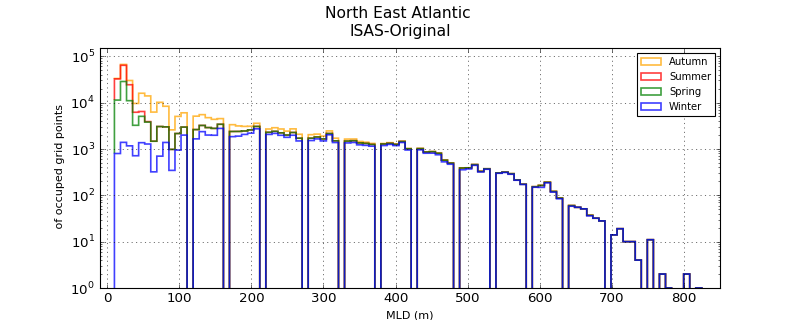

In [34]:
### Stacked histogram: No normalized, no cumulative, 
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=False)

ax.hist(data1, 100, range=ran_n1,  histtype='step', 
        align='mid', stacked=True, cumulative=False, color=colors, 
        label=labels, alpha=0.75, normed=False, linewidth=1.5)


fig.suptitle('North East Atlantic \nISAS-Original', fontsize=14)
ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-10, xlims_n[1])
ax.set_ylim(1e0, ylims_n[1])
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel(' of occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.45, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Noe-PDF-4SS-ISAS-000.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


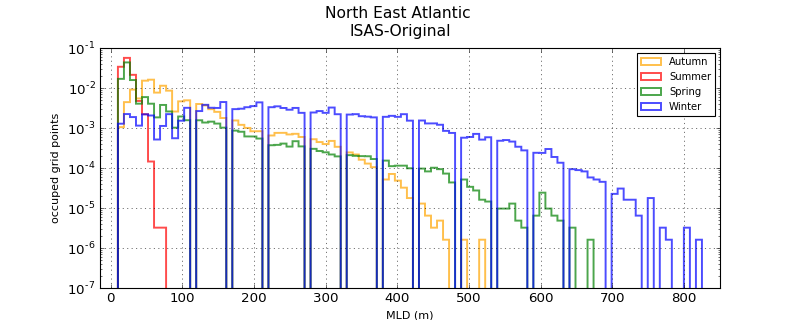

In [35]:
### No stacked: Normalized, no cumulative
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data1, 100, range=ran_n1, histtype='step', 
        align='mid', stacked=False, normed=True, cumulative=False,
        color=colors, label=labels, alpha=0.7, linewidth=1.75)

fig.suptitle('North East Atlantic \nISAS-Original', fontsize=14)

ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-15., xlims_n[1])
ax.set_ylim(1e-7, 1e-1)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Noe-PDF-4SN-ISAS-000.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


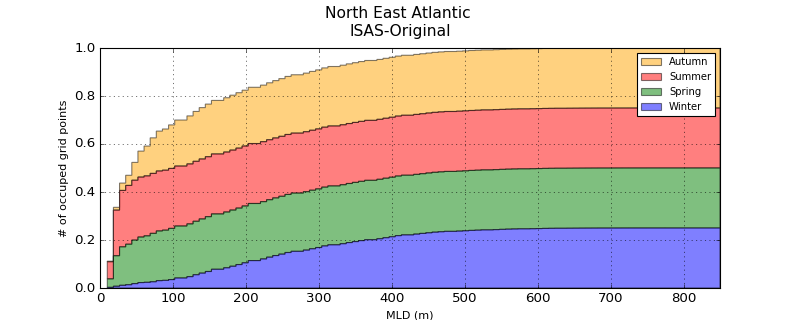

In [36]:
### Cumulative: No stacked, normalized
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data1, 100, range=ran_n1, histtype='stepfilled', align='mid',
        stacked=True, normed=True, cumulative=True,
        color=colors, label=labels, alpha=0.5)

fig.suptitle('North East Atlantic \nISAS-Original', fontsize=14)

#ax.set_yscale("log", nonposy='clip')
ax.set_xlim(0., xlims_n[1])
ax.set_ylim(0., 1.)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('# of occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Noe-PDF-4SC-ISAS-000.png', bbox_inches='tight')
plt.show()

### 1.2.  ISAS-0.015
   This means that for each time step (monthly data), the region will be represented by an estimate of 2550 grid points. Roughly speaking, then, for this region we will find 3.06e5 grid points for all the years.

In [39]:
###### Preparing the plot for the North East Region
## This histogram is for all data contained in the 
## in the complete region of Northe East in mld_a and mld_i. 
## For this region isas contains 120*50*51 = 3.06e5 grid points

coord = 'noe'
reg_noe3 = Crops(coord, c_isas3)

xlims_n = 10, 850
ylims_n = 1e-2, 1.5e5

In [40]:
mask = reg_noe3.time.dt.month 
reg_noe3.coords['month'] = (('time'), mask)

In [41]:
winter_n3 = Season(reg_noe3, 1, 3)
spring_n3 = Season(reg_noe3, 4, 6)
summer_n3 = Season(reg_noe3, 7, 9)
autumn_n3 = Season(reg_noe3, 10, 12)

In [42]:
ran_n3 = (xlims_n) 
a12_n3 = Lists(winter_n3.MLDP)
a22_n3 = Lists(spring_n3.MLDP)
a32_n3 = Lists(summer_n3.MLDP)
a42_n3 = Lists(autumn_n3.MLDP)

In [43]:
data3 = [a12_n3, a22_n3, a32_n3, a42_n3]

In [44]:
print(a12_n3.size + a22_n3.size + a32_n3.size + a42_n3.size)

413448


<IPython.core.display.Javascript object>


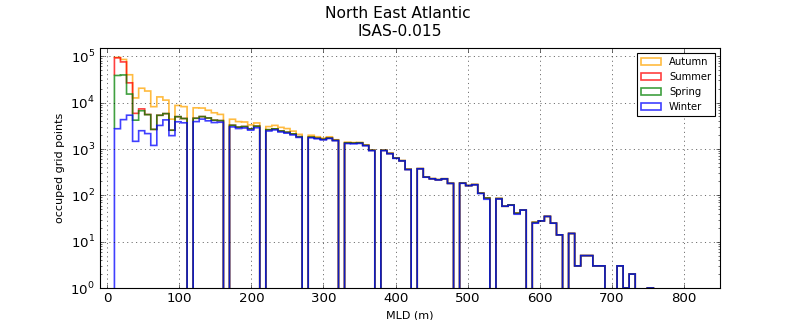

In [45]:
### Stacked histogram: No normalized, no cumulative, 
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=False)

ax.hist(data3, 100, range=ran_n3,  histtype='step', 
        align='mid', stacked=True, cumulative=False, color=colors, 
        label=labels, alpha=0.75, normed=False, linewidth=1.5)


fig.suptitle('North East Atlantic \nISAS-0.015', fontsize=14)
ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-10, xlims_n[1])
ax.set_ylim(1e0, ylims_n[1])
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.45, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Noe-PDF-4SS-ISAS-015.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


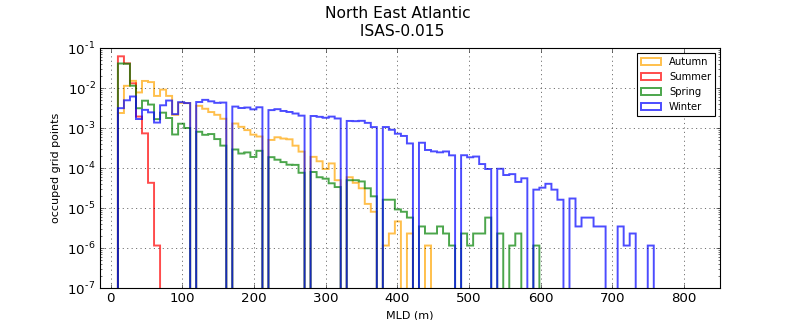

In [46]:
### No stacked: Normalized, no cumulative
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data3, 100, range=ran_n3, histtype='step', 
        align='mid', stacked=False, normed=True, cumulative=False,
        color=colors, label=labels, alpha=0.7, linewidth=1.75)

fig.suptitle('North East Atlantic \n ISAS-0.015', fontsize=14)

ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-15., xlims_n[1])
ax.set_ylim(1e-7, 1e-1)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Noe-PDF-4SN-ISAS-015.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


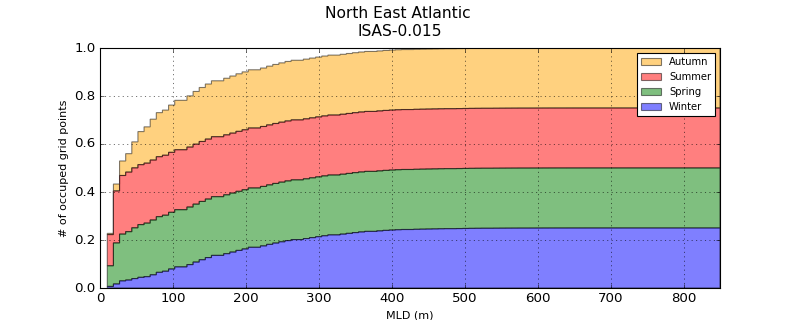

In [47]:
### Cumulative: No stacked, normalized
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data3, 100, range=ran_n3, histtype='stepfilled', align='mid',
        stacked=True, normed=True, cumulative=True,
        color=colors, label=labels, alpha=0.5)

fig.suptitle('North East Atlantic \nISAS-0.015', fontsize=14)

#ax.set_yscale("log", nonposy='clip')
ax.set_xlim(0., xlims_n[1])
ax.set_ylim(0., 1.)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('# of occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Noe-PDF-4SC-ISAS-015.png', bbox_inches='tight')
plt.show()

### 1.2.  ISAS-0.046
   This means that for each time step (monthly data), the region will be represented by an estimate of 2550 grid points. Roughly speaking, then, for this region we will find 3.06e5 grid points for all the years.

In [48]:
###### Preparing the plot for the North East Region
## This histogram is for all data contained in the 
## in the complete region of Northe East in mld_a and mld_i. 
## For this region isas contains 120*50*51 = 3.06e5 grid points

coord = 'noe'
reg_noe4 = Crops(coord, c_isas4)

xlims_n = 10, 850
ylims_n = 1e-2, 1.5e5

In [49]:
mask = reg_noe4.time.dt.month 
reg_noe4.coords['month'] = (('time'), mask)

In [50]:
winter_n4 = Season(reg_noe4, 1, 3)
spring_n4 = Season(reg_noe4, 4, 6)
summer_n4 = Season(reg_noe4, 7, 9)
autumn_n4 = Season(reg_noe4, 10, 12)

In [51]:
ran_n4 = (xlims_n) 
a12_n4 = Lists(winter_n4.MLDP)
a22_n4 = Lists(spring_n4.MLDP)
a32_n4 = Lists(summer_n4.MLDP)
a42_n4 = Lists(autumn_n4.MLDP)

In [52]:
data4 = [a12_n4, a22_n4, a32_n4, a42_n4]

In [53]:
print(a12_n4.size + a22_n4.size + a32_n4.size + a42_n4.size)

413448


<IPython.core.display.Javascript object>


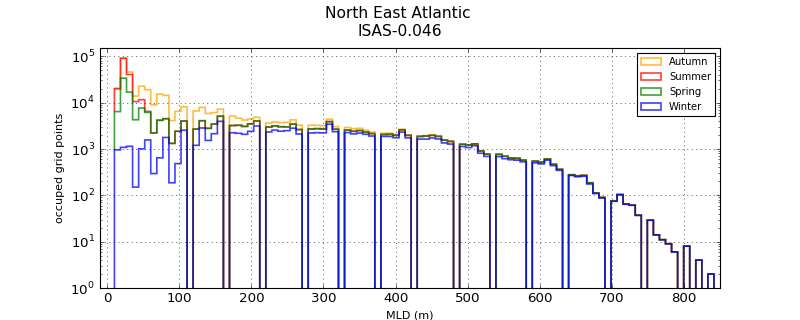

In [54]:
### Stacked histogram: No normalized, no cumulative, 
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=False)

ax.hist(data4, 100, range=ran_n4,  histtype='step', 
        align='mid', stacked=True, cumulative=False, color=colors, 
        label=labels, alpha=0.75, normed=False, linewidth=1.5)


fig.suptitle('North East Atlantic \nISAS-0.046', fontsize=14)
ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-10, xlims_n[1])
ax.set_ylim(1e0, ylims_n[1])
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.45, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Noe-PDF-4SS-ISAS-046.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


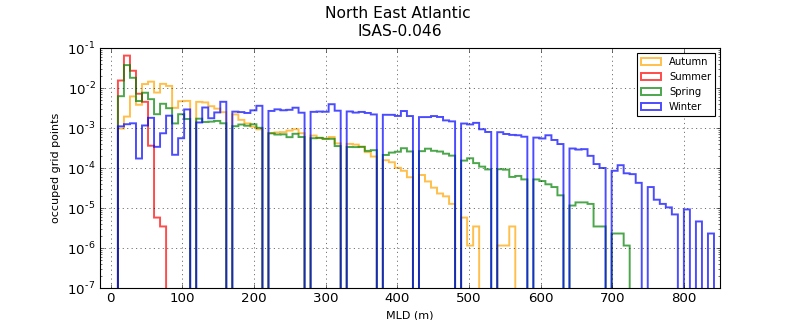

In [55]:
### No stacked: Normalized, no cumulative
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data4, 100, range=ran_n4, histtype='step', 
        align='mid', stacked=False, normed=True, cumulative=False,
        color=colors, label=labels, alpha=0.7, linewidth=1.75)

fig.suptitle('North East Atlantic \nISAS-0.046', fontsize=14)

ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-15., xlims_n[1])
ax.set_ylim(1e-7, 1e-1)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Noe-PDF-4SN-ISAS-046.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


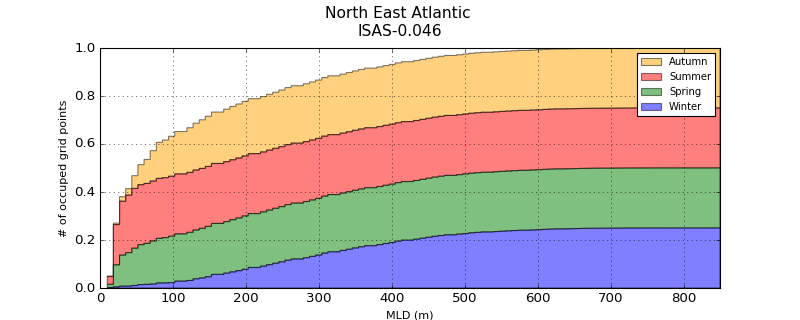

In [56]:
### Cumulative: No stacked, normalized
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data4, 100, range=ran_n4, histtype='stepfilled', align='mid',
        stacked=True, normed=True, cumulative=True,
        color=colors, label=labels, alpha=0.5)

fig.suptitle('North East Atlantic \nISAS-0.046', fontsize=14)

ax.set_xlim(0., xlims_n[1])
ax.set_ylim(0., 1.)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('# of occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

plt.savefig(dir_o + 'Noe-PDF-4SC-ISAS-046.png', bbox_inches='tight')
plt.show()

## 2. Labrador and Irminger seas

This region spans in longitude (60W, 30W), latitude (50N, 65N), occuping 30x15 degrees. 




 ### 2.1.  ISAS-Original: 
   This means that for each time step (weekly data), the region will be represented by an estimate of 7200 grid points. Roughly speaking, then, for this region we will find 5.256e6 grid points for all the years.

In [57]:
###### Preparing the plot for the Labrador and Irminger Seas
## This histogram is for all data contained in the 
## in the complete region of Labrador/Irminger in mld_a and mld_i. 
## For isas contains 120*57*61  = 4.1724e5 grid points

coord = 'lab'
reg_labA = Crops(coord, c_isas1)

xlims_l = 0, 2000
ylims_l = 1e-2, 1e6

In [58]:
mask = reg_labA.time.dt.month 
reg_labA.coords['month'] = (('time'), mask)

In [59]:
winter_l = Season(reg_labA, 1, 3)
spring_l = Season(reg_labA, 4, 6)
summer_l = Season(reg_labA, 7, 9)
autumn_l = Season(reg_labA, 10, 12)

In [60]:
ran_l1 = (xlims_l) 
a12_l1 = Lists(winter_l.MLDP)
a22_l1 = Lists(spring_l.MLDP)
a32_l1 = Lists(summer_l.MLDP)
a42_l1 = Lists(autumn_l.MLDP)

In [61]:
data_l1 = [a12_l1, a22_l1, a32_l1, a42_l1]

In [62]:
print(a12_l1.size + a22_l1.size + a32_l1.size + a42_l1.size)

362400


<IPython.core.display.Javascript object>


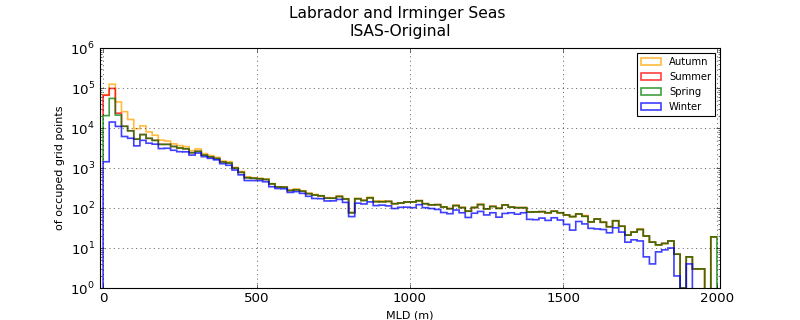

In [65]:
### Stacked histogram: No normalized, no cumulative, 
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=False)

ax.hist(data_l1, 100, range=ran_l1,  histtype='step', 
        align='mid', stacked=True, cumulative=False, color=colors, 
        label=labels, alpha=0.75, normed=False, linewidth=1.5)


fig.suptitle('Labrador and Irminger Seas \nISAS-Original', fontsize=14)
ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-10, xlims_l[1]+10.)
ax.set_ylim(1e0, ylims_l[1])
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('of occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.45, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Lab-PDF-4SS-ISAS-000.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


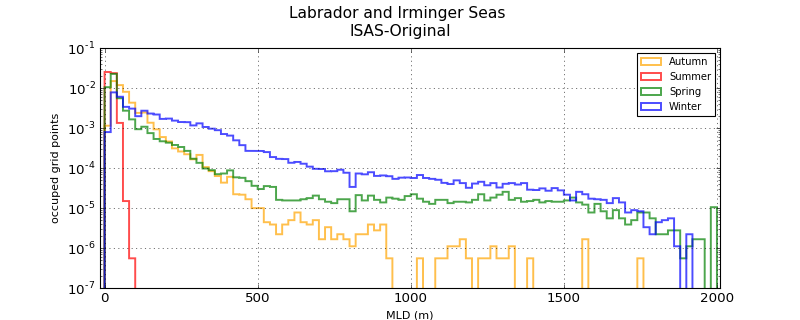

In [66]:
### No stacked: Normalized, no cumulative
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_l1, 100, range=ran_l1, histtype='step', 
        align='mid', stacked=False, normed=True, cumulative=False,
        color=colors, label=labels, alpha=0.7, linewidth=1.75)

fig.suptitle('Labrador and Irminger Seas \nISAS-Original', fontsize=14)

ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-15., xlims_l[1]+10.)
ax.set_ylim(1e-7, 1e-1)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

plt.savefig(dir_o + 'Lab-PDF-4SN-ISAS-000.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


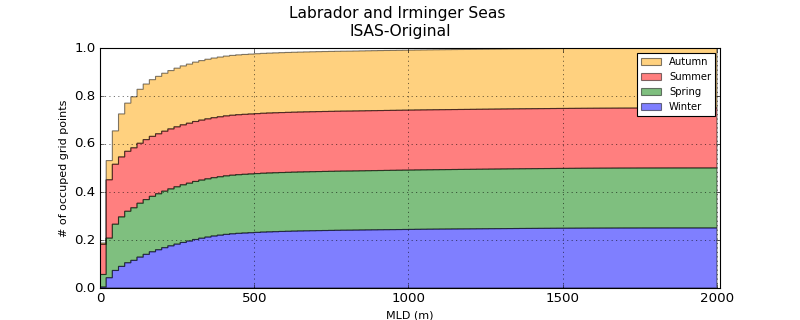

In [67]:
### Cumulative: No stacked, normalized
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_l1, 100, range=ran_l1, histtype='stepfilled', align='mid',
        stacked=True, normed=True, cumulative=True,
        color=colors, label=labels, alpha=0.5)

fig.suptitle('Labrador and Irminger Seas \nISAS-Original', fontsize=14)

#ax.set_yscale("log", nonposy='clip')
ax.set_xlim(0., xlims_l[1]+10.)
ax.set_ylim(0., 1.)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('# of occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Noe-PDF-4SC-ISAS-000.png', bbox_inches='tight')
plt.show()


 ### 2.2.  ISAS-015 
   This means that for each time step (weekly data), the region will be represented by an estimate of 7200 grid points. Roughly speaking, then, for this region we will find 5.256e6 grid points for all the years.

In [68]:
###### Preparing the plot for the Labrador and Irminger Seas
## This histogram is for all data contained in the 
## in the complete region of Labrador/Irminger in mld_a and mld_i. 
## For isas contains 120*57*61  = 4.1724e5 grid points

coord = 'lab'
reg_lab3 = Crops(coord, c_isas3)

xlims_l = 10, 2000
ylims_l = 1e-2, 1e6

In [69]:
mask = reg_lab3.time.dt.month 
reg_lab3.coords['month'] = (('time'), mask)

In [70]:
winter_l3 = Season(reg_lab3, 1, 3)
spring_l3 = Season(reg_lab3, 4, 6)
summer_l3 = Season(reg_lab3, 7, 9)
autumn_l3 = Season(reg_lab3, 10, 12)

In [71]:
ran_l3 = (xlims_l) 
a12_l3 = Lists(winter_l3.MLDP)
a22_l3 = Lists(spring_l3.MLDP)
a32_l3 = Lists(summer_l3.MLDP)
a42_l3 = Lists(autumn_l3.MLDP)

In [72]:
data_l3 = [a12_l3, a22_l3, a32_l3, a42_l3]

In [73]:
print(a12_l3.size + a22_l3.size + a32_l3.size + a42_l3.size)

507360


<IPython.core.display.Javascript object>


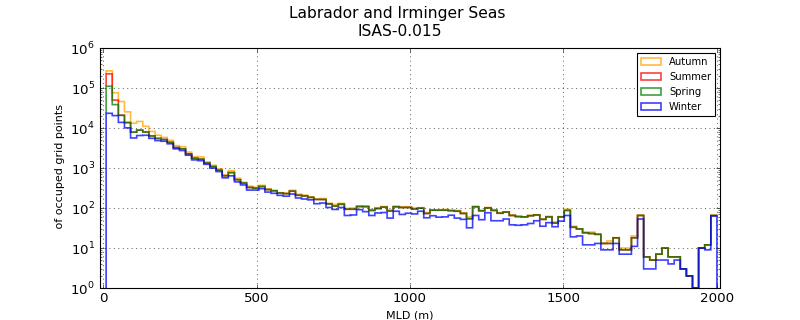

In [74]:
### Stacked histogram: No normalized, no cumulative, 
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=False)

ax.hist(data_l3, 100, range=ran_l3,  histtype='step', 
        align='mid', stacked=True, cumulative=False, color=colors, 
        label=labels, alpha=0.75, normed=False, linewidth=1.5)


fig.suptitle('Labrador and Irminger Seas \nISAS-0.015', fontsize=14)
ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-10, xlims_l[1]+10.)
ax.set_ylim(1e0, ylims_l[1])
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel(' of occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.45, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Lab-PDF-4SS-ISAS-015.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


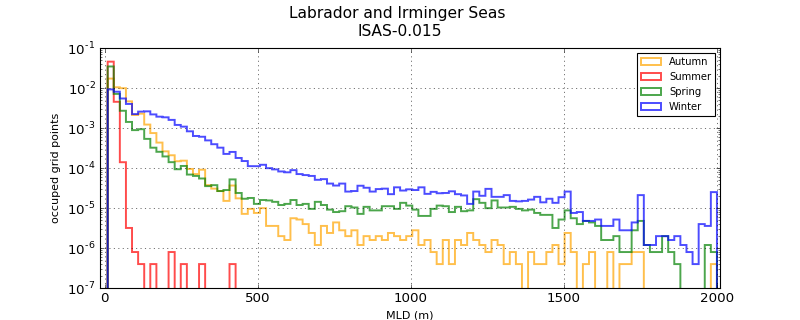

In [75]:
### No stacked: Normalized, no cumulative
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_l3, 100, range=ran_l3, histtype='step', 
        align='mid', stacked=False, normed=True, cumulative=False,
        color=colors, label=labels, alpha=0.7, linewidth=1.75)

fig.suptitle('Labrador and Irminger Seas \nISAS-0.015', fontsize=14)

ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-15., xlims_l[1]+10.)
ax.set_ylim(1e-7, 1e-1)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

plt.savefig(dir_o + 'Lab-PDF-4SN-ISAS-015.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


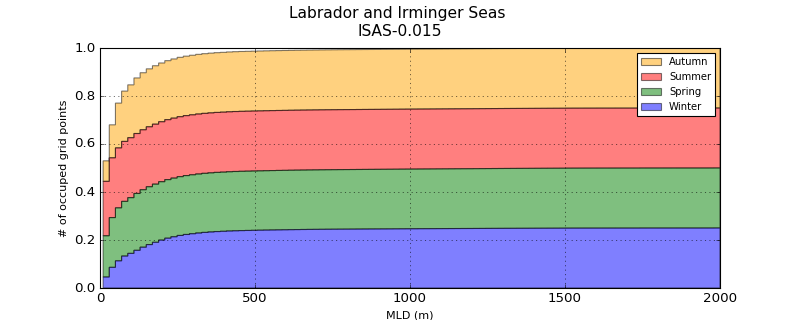

In [76]:
### Cumulative: No stacked, normalized
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_l3, 100, range=ran_l3, histtype='stepfilled', align='mid',
        stacked=True, normed=True, cumulative=True,
        color=colors, label=labels, alpha=0.5)

fig.suptitle('Labrador and Irminger Seas \nISAS-0.015', fontsize=14)

#ax.set_yscale("log", nonposy='clip')
ax.set_xlim(0., xlims_l[1])
ax.set_ylim(0., 1.)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('# of occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Noe-PDF-4SC-ISAS-015.png', bbox_inches='tight')
plt.show()


 ### 2.3.  ISAS-046
   This means that for each time step (weekly data), the region will be represented by an estimate of 7200 grid points. Roughly speaking, then, for this region we will find 5.256e6 grid points for all the years.

In [77]:
###### Preparing the plot for the Labrador and Irminger Seas
## This histogram is for all data contained in the 
## in the complete region of Labrador/Irminger in mld_a and mld_i. 
## For isas contains 120*57*61  = 4.1724e5 grid points

coord = 'lab'
reg_lab4 = Crops(coord, c_isas4)

xlims_l = 10, 2000
ylims_l = 1e-2, 1e6

In [78]:
mask = reg_lab4.time.dt.month 
reg_lab4.coords['month'] = (('time'), mask)

In [79]:
winter_l4 = Season(reg_lab4, 1, 3)
spring_l4 = Season(reg_lab4, 4, 6)
summer_l4 = Season(reg_lab4, 7, 9)
autumn_l4 = Season(reg_lab4, 10, 12)

In [80]:
ran_l4 = (xlims_l) 
a12_l4 = Lists(winter_l4.MLDP)
a22_l4 = Lists(spring_l4.MLDP)
a32_l4 = Lists(summer_l4.MLDP)
a42_l4 = Lists(autumn_l4.MLDP)

In [81]:
data_l4 = [a12_l4, a22_l4, a32_l4, a42_l4]

In [82]:
print(a12_l4.size + a22_l4.size + a32_l4.size + a42_l4.size)

507360


<IPython.core.display.Javascript object>


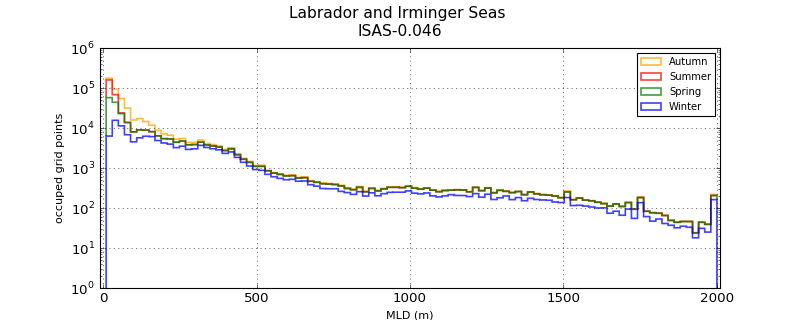

In [84]:
### Stacked histogram: No normalized, no cumulative, 
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=False)

ax.hist(data_l4, 100, range=ran_l4,  histtype='step', 
        align='mid', stacked=True, cumulative=False, color=colors, 
        label=labels, alpha=0.75, normed=False, linewidth=1.5)


fig.suptitle('Labrador and Irminger Seas \nISAS-0.046', fontsize=14)
ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-10, xlims_l[1]+10.)
ax.set_ylim(1e0, ylims_l[1])
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.45, hspace=0.5)

plt.legend(fontsize=9)

plt.savefig(dir_o + 'Lab-PDF-4SS-ISAS-046.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


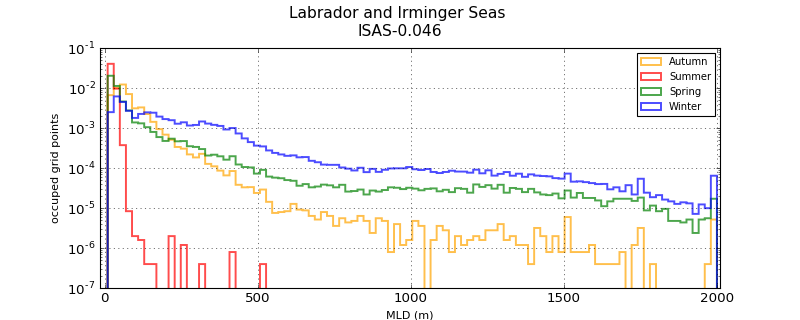

In [85]:
### No stacked: Normalized, no cumulative
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_l4, 100, range=ran_l4, histtype='step', 
        align='mid', stacked=False, normed=True, cumulative=False,
        color=colors, label=labels, alpha=0.7, linewidth=1.75)

fig.suptitle('Labrador and Irminger Seas \nISAS-0.046', fontsize=14)

ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-15., xlims_l[1]+10.)
ax.set_ylim(1e-7, 1e-1)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Lab-PDF-4SN-ISAS-046.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


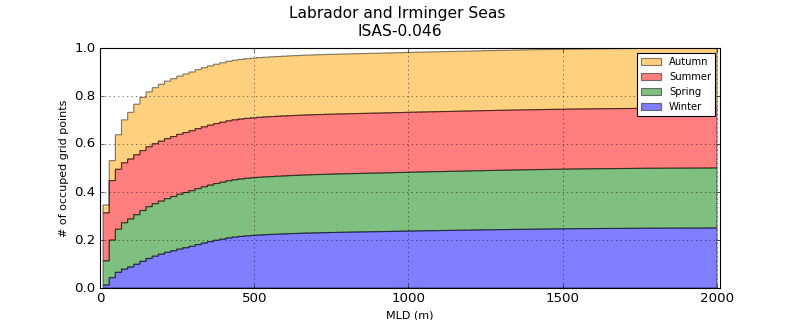

In [86]:
### Cumulative: No stacked, normalized
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_l4, 100, range=ran_l4, histtype='stepfilled', align='mid',
        stacked=True, normed=True, cumulative=True,
        color=colors, label=labels, alpha=0.5)

fig.suptitle('Labrador and Irminger Seas \nISAS-0.046', fontsize=14)

#ax.set_yscale("log", nonposy='clip')
ax.set_xlim(0., xlims_l[1]+10.)
ax.set_ylim(0., 1.)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('# of occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Lab-PDF-4SC-ISAS-046.png', bbox_inches='tight')
plt.show()

## 3. Gulf Stream

This region spans in llongitude (75W, 45W), latitude (30N, 45N), being a region of 30x15 degrees.


 ### 3.1.  ISAS-Original
   This means that for each time step (weekly data), the region will be represented by an estimate of 7200 grid points. Roughly speaking, then, for this region we will find 5.256e6 grid points for all the years.

In [96]:
###### Preparing the plot for the Labrador and Irminger Seas
## This histogram is for all data contained in the 
## in the complete region of Labrador/Irminger in mld_a and mld_i. 
## For isas contains 120*57*61  = 4.1724e5 grid points

coord = 'gul'
reg_gul1 = Crops(coord, c_isas1)

xlims_g = 10, 560
ylims_g = 1e-2, 1.5e5

In [97]:
mask = reg_gul1.time.dt.month 
reg_gul1.coords['month'] = (('time'), mask)

In [98]:
winter_g1 = Season(reg_gul1, 1, 3)
spring_g1 = Season(reg_gul1, 4, 6)
summer_g1 = Season(reg_gul1, 7, 9)
autumn_g1 = Season(reg_gul1, 10, 12)

In [99]:
ran_g1 = (xlims_g) 
a12_g1 = Lists(winter_g1.MLDP)
a22_g1 = Lists(spring_g1.MLDP)
a32_g1 = Lists(summer_g1.MLDP)
a42_g1 = Lists(autumn_g1.MLDP)

In [100]:
data_g1 = [a12_g1, a22_g1, a32_g1, a42_g1]

In [101]:
print(a12_g1.size + a22_g1.size + a32_g1.size + a42_g1.size)

262920


<IPython.core.display.Javascript object>


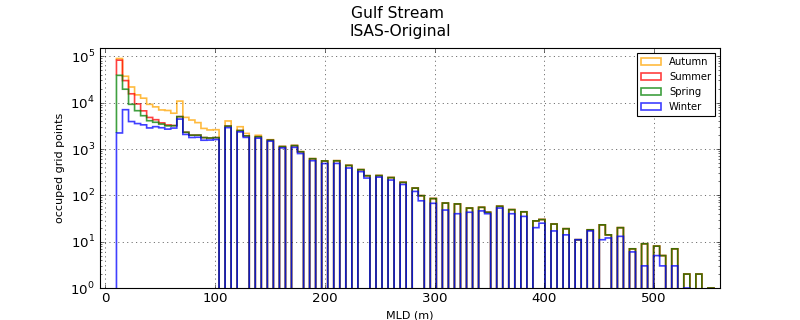

In [102]:
### Stacked histogram: No normalized, no cumulative, 
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=False)

ax.hist(data_g1, 100, range=ran_g1,  histtype='step', 
        align='mid', stacked=True, cumulative=False, color=colors, 
        label=labels, alpha=0.75, normed=False, linewidth=1.5)


fig.suptitle('Gulf Stream \nISAS-Original', fontsize=14)
ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-5, xlims_g[1])
ax.set_ylim(1e0, ylims_g[1])
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.45, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Gul-PDF-4SS-ISAS-000.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


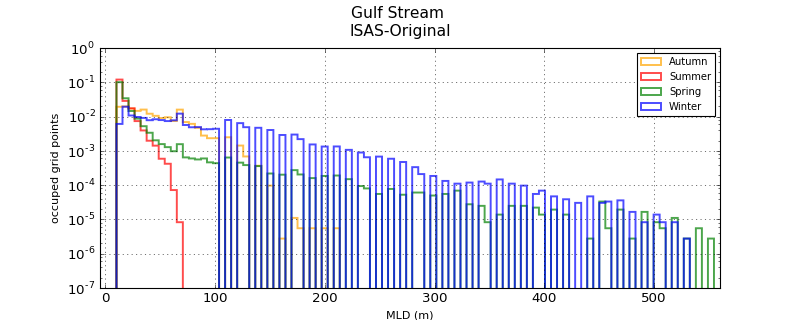

In [103]:
### No stacked: Normalized, no cumulative
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_g1, 100, range=ran_g1, histtype='step', 
        align='mid', stacked=False, normed=True, cumulative=False,
        color=colors, label=labels, alpha=0.7, linewidth=1.75)

fig.suptitle('Gulf Stream \nISAS-Original', fontsize=14)

ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-5., xlims_g[1])
ax.set_ylim(1e-7, 1e0)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

plt.savefig(dir_o + 'Gul-PDF-4SN-ISAS-000.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


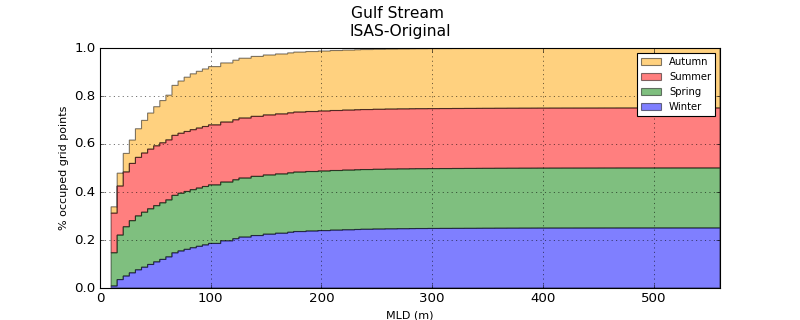

In [104]:
### Cumulative: No stacked, normalized
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_g1, 100, range=ran_g1, histtype='stepfilled', align='mid',
        stacked=True, normed=True, cumulative=True,
        color=colors, label=labels, alpha=0.5)

fig.suptitle('Gulf Stream \nISAS-Original', fontsize=14)

#ax.set_yscale("log", nonposy='clip')
ax.set_xlim(0., xlims_g[1])
ax.set_ylim(0., 1.)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('% occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Gul-PDF-4SC-ISAS-000.png', bbox_inches='tight')
plt.show()


 ### 3.2.  ISAS-0.015
   This means that for each time step (weekly data), the region will be represented by an estimate of 7200 grid points. Roughly speaking, then, for this region we will find 5.256e6 grid points for all the years.

In [105]:
###### Preparing the plot for the Labrador and Irminger Seas
## This histogram is for all data contained in the 
## in the complete region of Labrador/Irminger in mld_a and mld_i. 
## For isas contains 120*57*61  = 4.1724e5 grid points

coord = 'gul'
reg_gul3 = Crops(coord, c_isas3)

xlims_g = 10, 560
ylims_g = 1e-2, 1e6

In [106]:
mask = reg_gul3.time.dt.month 
reg_gul3.coords['month'] = (('time'), mask)

In [107]:
winter_g3 = Season(reg_gul3, 1, 3)
spring_g3 = Season(reg_gul3, 4, 6)
summer_g3 = Season(reg_gul3, 7, 9)
autumn_g3 = Season(reg_gul3, 10, 12)

In [108]:
ran_g3 = (xlims_g) 
a12_g3 = Lists(winter_g3.MLDP)
a22_g3 = Lists(spring_g3.MLDP)
a32_g3 = Lists(summer_g3.MLDP)
a42_g3 = Lists(autumn_g3.MLDP)

In [109]:
data_g3 = [a12_g3, a22_g3, a32_g3, a42_g3]

In [110]:
print(a12_g3.size + a22_g3.size + a32_g3.size + a42_g3.size)

368088


<IPython.core.display.Javascript object>


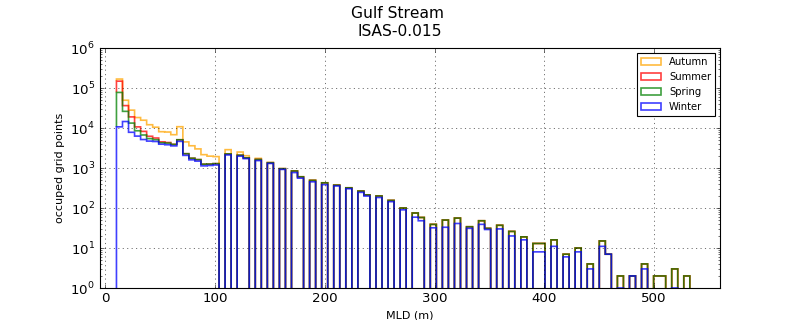

In [113]:
### Stacked histogram: No normalized, no cumulative, 
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=False)

ax.hist(data_g3, 100, range=ran_g3,  histtype='step', 
        align='mid', stacked=True, cumulative=False, color=colors, 
        label=labels, alpha=0.75, normed=False, linewidth=1.5)


fig.suptitle('Gulf Stream \nISAS-0.015', fontsize=14)
ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-5, xlims_g[1])
ax.set_ylim(1e0, ylims_g[1])
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.45, hspace=0.5)

plt.legend(fontsize=9)

plt.savefig(dir_o + 'Gul-PDF-4SS-ISAS-015.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


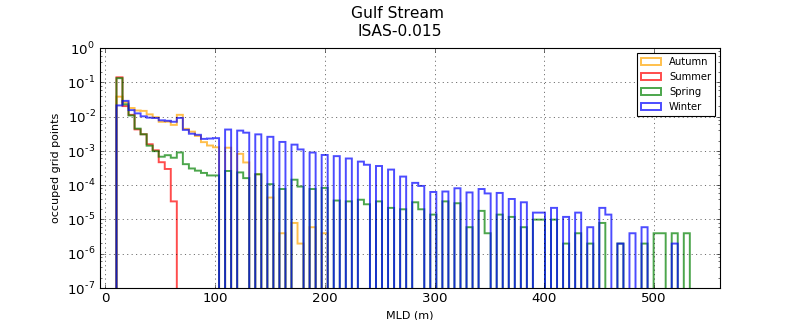

In [112]:
### No stacked: Normalized, no cumulative
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_g3, 100, range=ran_g3, histtype='step', 
        align='mid', stacked=False, normed=True, cumulative=False,
        color=colors, label=labels, alpha=0.7, linewidth=1.75)

fig.suptitle('Gulf Stream \nISAS-0.015', fontsize=14)

ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-5., xlims_g[1])
ax.set_ylim(1e-7, 1e0)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Gul-PDF-4SN-ISAS-015.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


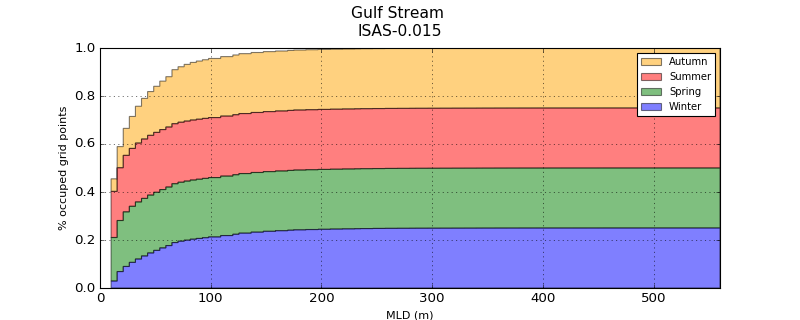

In [114]:
### Cumulative: No stacked, normalized
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_g3, 100, range=ran_g3, histtype='stepfilled', align='mid',
        stacked=True, normed=True, cumulative=True,
        color=colors, label=labels, alpha=0.5)

fig.suptitle('Gulf Stream \nISAS-0.015', fontsize=14)

#ax.set_yscale("log", nonposy='clip')
ax.set_xlim(0., xlims_g[1])
ax.set_ylim(0., 1.)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('% occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Gul-PDF-4SC-ISAS-015.png', bbox_inches='tight')
plt.show()


 ### 3.3.  ISAS-0.046
   This means that for each time step (weekly data), the region will be represented by an estimate of 7200 grid points. Roughly speaking, then, for this region we will find 5.256e6 grid points for all the years.

In [115]:
###### Preparing the plot for the Labrador and Irminger Seas
## This histogram is for all data contained in the 
## in the complete region of Labrador/Irminger in mld_a and mld_i. 
## For isas contains 120*57*61  = 4.1724e5 grid points

coord = 'gul'
reg_gul4 = Crops(coord, c_isas4)

xlims_g = 10, 560
ylims_g = 1e-2, 1.5e5

In [116]:
mask = reg_gul4.time.dt.month 
reg_gul4.coords['month'] = (('time'), mask)

In [117]:
winter_g4 = Season(reg_gul4, 1, 3)
spring_g4 = Season(reg_gul4, 4, 6)
summer_g4 = Season(reg_gul4, 7, 9)
autumn_g4 = Season(reg_gul4, 10, 12)

In [118]:
ran_g4 = (xlims_g) 
a12_g4 = Lists(winter_g4.MLDP)
a22_g4 = Lists(spring_g4.MLDP)
a32_g4 = Lists(summer_g4.MLDP)
a42_g4 = Lists(autumn_g4.MLDP)

In [119]:
data_g4 = [a12_g4, a22_g4, a32_g4, a42_g4]

In [120]:
print(a12_g4.size + a22_g4.size + a32_g4.size + a42_g4.size)

368088


<IPython.core.display.Javascript object>


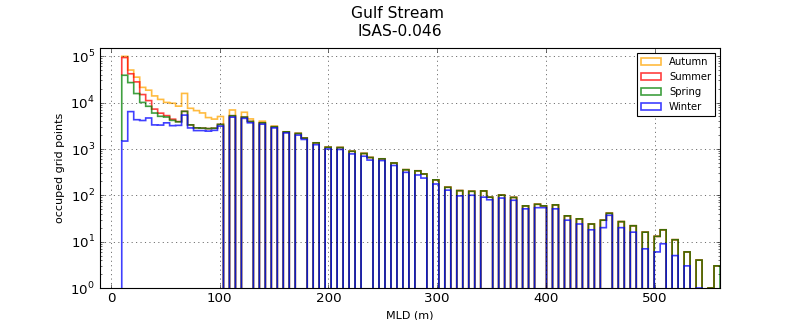

In [121]:
### Stacked histogram: No normalized, no cumulative, 
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=False)

ax.hist(data_g4, 100, range=ran_g4,  histtype='step', 
        align='mid', stacked=True, cumulative=False, color=colors, 
        label=labels, alpha=0.75, normed=False, linewidth=1.5)


fig.suptitle('Gulf Stream \nISAS-0.046', fontsize=14)
ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-10, xlims_g[1])
ax.set_ylim(1e0, ylims_g[1])
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.45, hspace=0.5)

plt.legend(fontsize=9)

plt.savefig(dir_o + 'Gul-PDF-4SS-ISAS-046.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


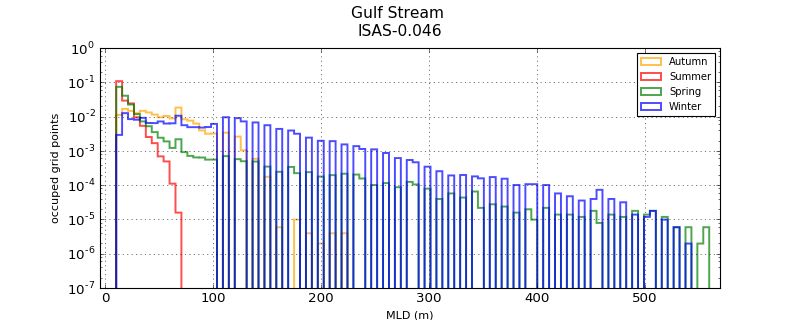

In [123]:
### No stacked: Normalized, no cumulative
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_g4, 100, range=ran_g4, histtype='step', 
        align='mid', stacked=False, normed=True, cumulative=False,
        color=colors, label=labels, alpha=0.7, linewidth=1.75)

fig.suptitle('Gulf Stream \nISAS-0.046', fontsize=14)

ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-5., xlims_g[1]+10.)
ax.set_ylim(1e-7, 1e0)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

plt.savefig(dir_o + 'Gul-PDF-4SN-ISAS-046.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


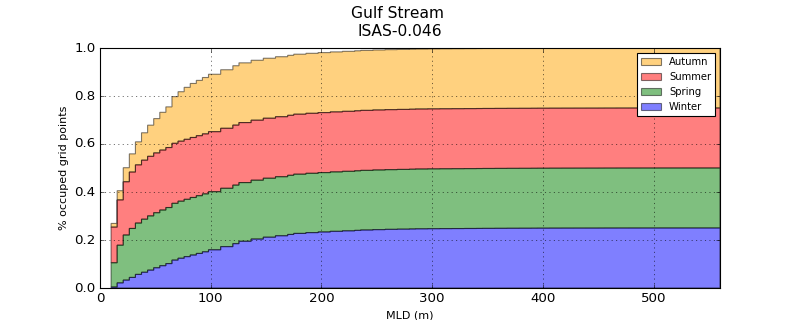

In [124]:
### Cumulative: No stacked, normalized
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_g4, 100, range=ran_g4, histtype='stepfilled', align='mid',
        stacked=True, normed=True, cumulative=True,
        color=colors, label=labels, alpha=0.5)

fig.suptitle('Gulf Stream \nISAS-0.046', fontsize=14)

#ax.set_yscale("log", nonposy='clip')
ax.set_xlim(0., xlims_g[1])
ax.set_ylim(0., 1.)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('% occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Gul-PDF-4SC-ISAS-046.png', bbox_inches='tight')
plt.show()

## 4. Nordic Seas

This region spans in llongitude (15W, 10E), latitude (65N, 80N), being a region of 25x15 degrees.


 ### 4.1.  ISAS-Original
   This means that for each time step (weekly data), the region will be represented by an estimate of 7200 grid points. Roughly speaking, then, for this region we will find 5.256e6 grid points for all the years.

In [125]:
###### Preparing the plot for the Labrador and Irminger Seas
## This histogram is for all data contained in the 
## in the complete region of Labrador/Irminger in mld_a and mld_i. 
## For isas contains 120*57*61  = 4.1724e5 grid points

coord = 'nor'
reg_nor1 = Crops(coord, c_isas1)

xlims_r = 10, 600
ylims_r = 1e-2, 1.5e5

In [126]:
mask = reg_nor1.time.dt.month 
reg_nor1.coords['month'] = (('time'), mask)

In [127]:
winter_r1 = Season(reg_nor1, 1, 3)
spring_r1 = Season(reg_nor1, 4, 6)
summer_r1 = Season(reg_nor1, 7, 9)
autumn_r1 = Season(reg_nor1, 10, 12)

In [128]:
ran_r1 = (xlims_r) 
a12_r1 = Lists(winter_r1.MLDP)
a22_r1 = Lists(spring_r1.MLDP)
a32_r1 = Lists(summer_r1.MLDP)
a42_r1 = Lists(autumn_r1.MLDP)

In [129]:
data_r1 = [a12_r1, a22_r1, a32_r1, a42_r1]

In [130]:
print(a12_r1.size + a22_r1.size + a32_r1.size + a42_r1.size)

451800


<IPython.core.display.Javascript object>


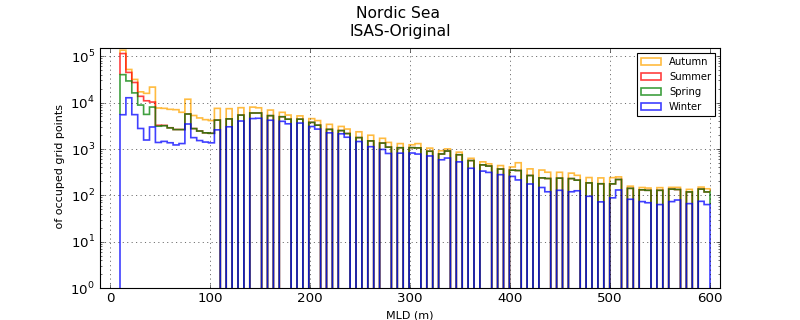

In [131]:
### Stacked histogram: No normalized, no cumulative, 
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=False)

ax.hist(data_r1, 100, range=ran_r1,  histtype='step', 
        align='mid', stacked=True, cumulative=False, color=colors, 
        label=labels, alpha=0.75, normed=False, linewidth=1.5)


fig.suptitle('Nordic Sea \nISAS-Original', fontsize=14)
ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-10, xlims_r[1]+10.)
ax.set_ylim(1e0, ylims_r[1])
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel(' of occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.45, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Nor-PDF-4SS-ISAS-000.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


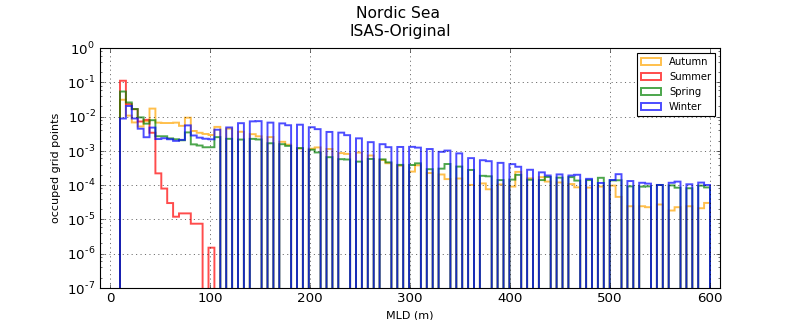

In [132]:
### No stacked: Normalized, no cumulative
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_r1, 100, range=ran_r1, histtype='step', 
        align='mid', stacked=False, normed=True, cumulative=False,
        color=colors, label=labels, alpha=0.7, linewidth=1.75)

fig.suptitle('Nordic Sea \nISAS-Original', fontsize=14)

ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-10., xlims_r[1]+10.)
ax.set_ylim(1e-7, 1e0)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Nor-PDF-4SN-ISAS-000.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


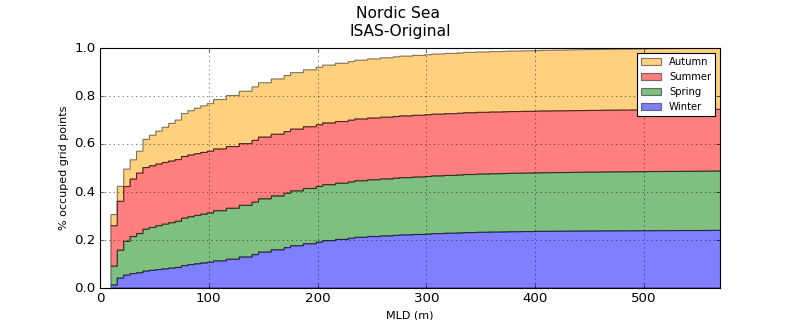

In [133]:
### Cumulative: No stacked, normalized
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_r1, 100, range=ran_r1, histtype='stepfilled', align='mid',
        stacked=True, normed=True, cumulative=True,
        color=colors, label=labels, alpha=0.5)

fig.suptitle('Nordic Sea \nISAS-Original', fontsize=14)

#ax.set_yscale("log", nonposy='clip')
ax.set_xlim(0., xlims_g[1]+10.)
ax.set_ylim(0., 1.)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('% occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Nor-PDF-4SC-ISAS-000.png', bbox_inches='tight')
plt.show()


 ### 4.2.  ISAS-0.015
   This means that for each time step (weekly data), the region will be represented by an estimate of 7200 grid points. Roughly speaking, then, for this region we will find 5.256e6 grid points for all the years.

In [134]:
###### Preparing the plot for the Labrador and Irminger Seas
## This histogram is for all data contained in the 
## in the complete region of Labrador/Irminger in mld_a and mld_i. 
## For isas contains 120*57*61  = 4.1724e5 grid points

coord = 'nor'
reg_nor3 = Crops(coord, c_isas3)

xlims_r = 10, 600
ylims_r = 1e-2, 1.5e6

In [135]:
mask = reg_nor3.time.dt.month 
reg_nor3.coords['month'] = (('time'), mask)

In [136]:
winter_r3 = Season(reg_nor3, 1, 3)
spring_r3 = Season(reg_nor3, 4, 6)
summer_r3 = Season(reg_nor3, 7, 9)
autumn_r3 = Season(reg_nor3, 10, 12)

In [137]:
ran_r3 = (xlims_r) 
a12_r3 = Lists(winter_r3.MLDP)
a22_r3 = Lists(spring_r3.MLDP)
a32_r3 = Lists(summer_r3.MLDP)
a42_r3 = Lists(autumn_r3.MLDP)

In [138]:
data_r3 = [a12_r3, a22_r3, a32_r3, a42_r3]

In [139]:
print(a12_r3.size + a22_r3.size + a32_r3.size + a42_r3.size)

632520


<IPython.core.display.Javascript object>


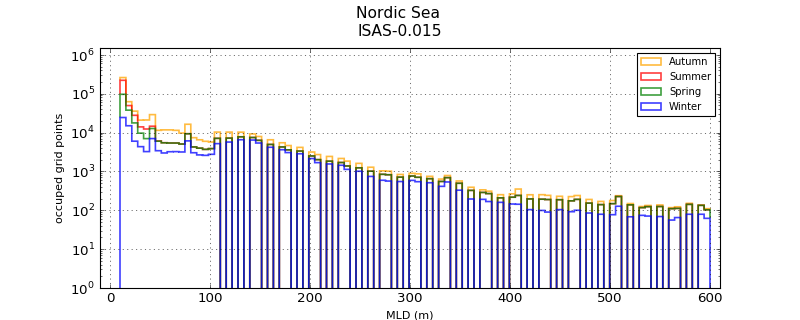

In [140]:
### Stacked histogram: No normalized, no cumulative, 
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=False)

ax.hist(data_r3, 100, range=ran_r3,  histtype='step', 
        align='mid', stacked=True, cumulative=False, color=colors, 
        label=labels, alpha=0.75, normed=False, linewidth=1.5)


fig.suptitle('Nordic Sea \nISAS-0.015', fontsize=14)
ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-10, xlims_r[1]+10.)
ax.set_ylim(1e0, ylims_r[1])
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.45, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Nor-PDF-4SS-ISAS-015.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


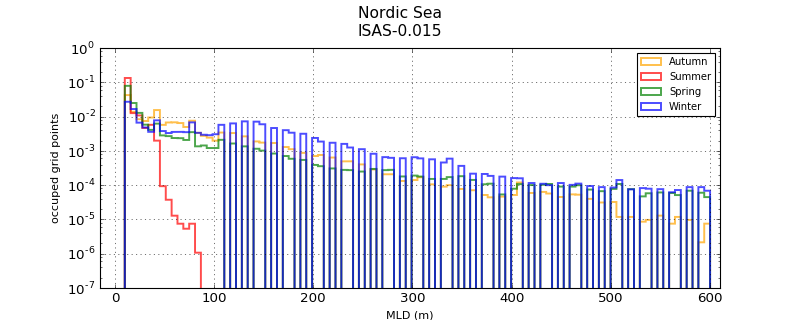

In [141]:
### No stacked: Normalized, no cumulative
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_r3, 100, range=ran_r3, histtype='step', 
        align='mid', stacked=False, normed=True, cumulative=False,
        color=colors, label=labels, alpha=0.7, linewidth=1.75)

fig.suptitle('Nordic Sea\nISAS-0.015', fontsize=14)

ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-15., xlims_r[1]+10.)
ax.set_ylim(1e-7, 1e0)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Nor-PDF-4SN-ISAS-015.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


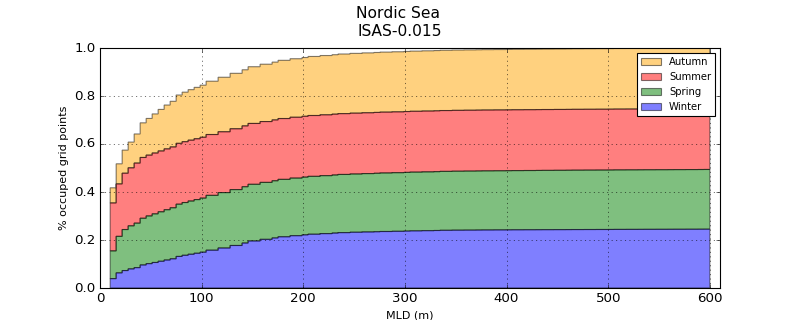

In [142]:
### Cumulative: No stacked, normalized
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_r3, 100, range=ran_r3, histtype='stepfilled', align='mid',
        stacked=True, normed=True, cumulative=True,
        color=colors, label=labels, alpha=0.5)

fig.suptitle('Nordic Sea \nISAS-0.015', fontsize=14)

#ax.set_yscale("log", nonposy='clip')
ax.set_xlim(0., xlims_r[1]+10.)
ax.set_ylim(0., 1.)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('% occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Nor-PDF-4SC-ISAS-015.png', bbox_inches='tight')
plt.show()


 ### 4.3.  ISAS-0.046
   This means that for each time step (weekly data), the region will be represented by an estimate of 7200 grid points. Roughly speaking, then, for this region we will find 5.256e6 grid points for all the years.

In [143]:
###### Preparing the plot for the Labrador and Irminger Seas
## This histogram is for all data contained in the 
## in the complete region of Labrador/Irminger in mld_a and mld_i. 
## For isas contains 120*57*61  = 4.1724e5 grid points

coord = 'nor'
reg_nor4 = Crops(coord, c_isas4)

xlims_r = 10, 600
ylims_r = 1e-2, 1e6

In [144]:
mask = reg_nor4.time.dt.month 
reg_nor4.coords['month'] = (('time'), mask)

In [145]:
winter_r4 = Season(reg_nor4, 1, 3)
spring_r4 = Season(reg_nor4, 4, 6)
summer_r4 = Season(reg_nor4, 7, 9)
autumn_r4 = Season(reg_nor4, 10, 12)

In [146]:
ran_r4 = (xlims_r) 
a12_r4 = Lists(winter_r4.MLDP)
a22_r4 = Lists(spring_r4.MLDP)
a32_r4 = Lists(summer_r4.MLDP)
a42_r4 = Lists(autumn_r4.MLDP)

In [147]:
data_r4 = [a12_r4, a22_r4, a32_r4, a42_r4]

In [148]:
print(a12_r4.size + a22_r4.size + a32_r4.size + a42_r4.size)

632520


<IPython.core.display.Javascript object>


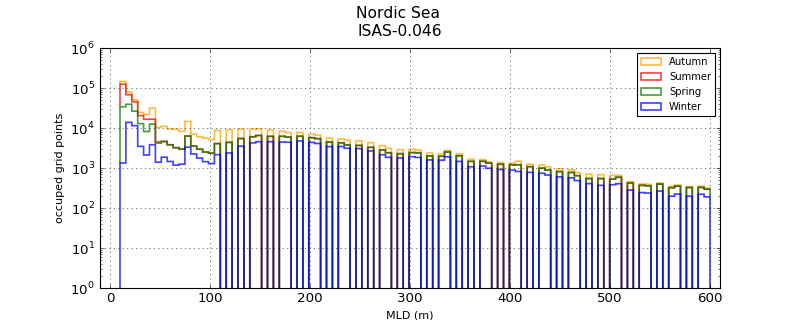

In [149]:
### Stacked histogram: No normalized, no cumulative, 
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=False)

ax.hist(data_r4, 100, range=ran_r4,  histtype='step', 
        align='mid', stacked=True, cumulative=False, color=colors, 
        label=labels, alpha=0.75, normed=False, linewidth=1.5)


fig.suptitle('Nordic Sea \nISAS-0.046', fontsize=14)
ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-10, xlims_r[1]+10.)
ax.set_ylim(1e0, ylims_r[1])
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.45, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Nor-PDF-4SS-ISAS-046.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


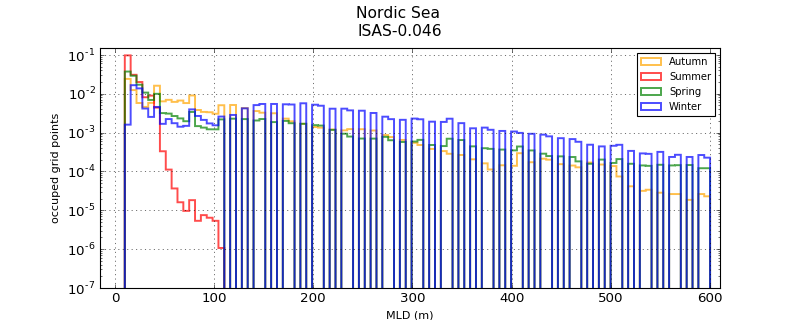

In [150]:
### No stacked: Normalized, no cumulative
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_r4, 100, range=ran_r4, histtype='step', 
        align='mid', stacked=False, normed=True, cumulative=False,
        color=colors, label=labels, alpha=0.7, linewidth=1.75)

fig.suptitle('Nordic Sea \nISAS-0.046', fontsize=14)

ax.set_yscale("log", nonposy='clip')
ax.set_xlim(-15., xlims_r[1]+10.)
ax.set_ylim(1e-7, 1.5e-1)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Nor-PDF-4SN-ISAS-046.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


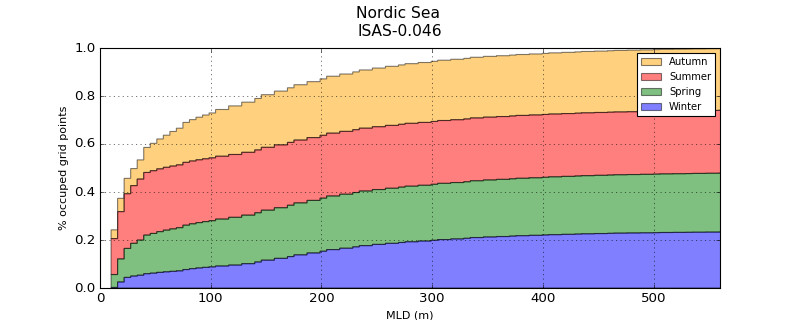

In [151]:
### Cumulative: No stacked, normalized
%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)

ax.hist(data_r4, 100, range=ran_r4, histtype='stepfilled', align='mid',
        stacked=True, normed=True, cumulative=True,
        color=colors, label=labels, alpha=0.5)

fig.suptitle('Nordic Sea \nISAS-0.046', fontsize=14)

#ax.set_yscale("log", nonposy='clip')
ax.set_xlim(0., xlims_g[1])
ax.set_ylim(0., 1.)
ax.set_xlabel('MLD (m)', fontsize=10)
ax.set_ylabel('% occuped grid points', fontsize=10)
ax.grid(True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                        top=0.85, wspace=0.25, hspace=0.5)

plt.legend(fontsize=9)

#plt.hlines(4396806, xlims_g[0], xlims_g[1])
plt.savefig(dir_o + 'Nor-PDF-4SC-ISAS-046.png', bbox_inches='tight')
plt.show()